<a href="https://colab.research.google.com/github/puevigreven/END2.0/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [3]:
import os
from google.colab import drive

In [24]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
train_set = datasets.MNIST('drive/My Drive/END2.0/MNIST_data/', download=True, train=True, transform=transform)
val_set = datasets.MNIST('drive/My Drive/END2.0/MNIST_data/', download=True, train=False, transform=transform)


In [5]:
sample = next(iter(train_set))
len(sample)

2

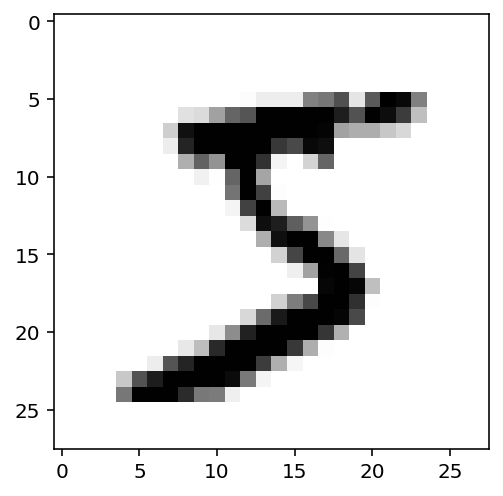

In [6]:
plt.imshow(sample[0].numpy().squeeze(), cmap='gray_r');

### Custom Dataset Class

In [92]:
from torch.utils.data import Dataset
from PIL import Image

class MNIST_Random(Dataset):
  def __init__(self, train_set):
    # train_set = datasets.MNIST('drive/My Drive/END2.0/MNIST_data/', download=True, train=True, transform=transform)
    self.data = train_set.data
    self.data = self.data.unsqueeze(1)
    self.data = self.data.float()
    
    self.targets = train_set.targets #mnist image true value 
    self.random_input = torch.randint(0,10, (len(train_set.data),)) # random input 
    self.label_2 = self.targets + self.random_input # sum of random input
    
  def __getitem__(self, index):
    img, targets, random_input, sum = self.data[index], int(self.targets[index]), int(self.random_input[index]), int(self.label_2[index])

    return img, targets, random_input, sum
  def __len__(self):
    return len(self.data)

### Model

In [135]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(20,20)
        self.fc4 = nn.Linear(20,19)
    def forward(self, x, random):
        random = F.one_hot(random, num_classes=10)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        mnist_output = self.fc2(x)
        # print(mnist_output.shape,random.shape )
        concat = torch.cat([mnist_output, random], dim=-1) # Concatinating the mnist output and random input
        x = self.fc3(concat)
        x = F.relu(x)
        x = self.fc4(concat)
        x = F.relu(x)
        # output = F.log_softmax(mnist_output, dim=1)
        # add_out =  F.log_softmax(x, dim=1)
        return mnist_output, x


def train(model, device, train_loader, optimizer, epoch, log_interval, dry_run):
    model.train()
    for batch_idx, (data, target, random_number, rand_sum) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        random_number, rand_sum = random_number.to(device), rand_sum.to(device)
        optimizer.zero_grad()
        output, add_out = model(data,random_number)
        loss = nn.CrossEntropyLoss()
        l1 = loss(output, target)
        l2 = loss(add_out, rand_sum)
        loss = l1 + l2
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


In [136]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target , random_number, rand_sum in test_loader:
            data, target = data.to(device), target.to(device)
            random_number, rand_sum = random_number.to(device), rand_sum.to(device)

            output, add_out = model(data,random_number)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# main function to run the training 
def main():

    use_cuda = torch.cuda.is_available()
    seed = 121
    batch_size = 32
    test_batch_size = 64
    lr = 0.001
    gamma = 0.7
    epochs = 15
    log_interval = 100
    dry_run = False
    save_model = False
    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('drive/My Drive/END2.0/MNIST_data/', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('drive/My Drive/END2.0/MNIST_data/', train=False,
                       transform=transform)
    dataset1 = MNIST_Random(dataset1)
    dataset2 = MNIST_Random(dataset2)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch, log_interval, dry_run)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")





In [137]:
main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 18.122763
Train Epoch: 1 [3200/60000 (5%)]	Loss: 10.193660
Train Epoch: 1 [6400/60000 (11%)]	Loss: 6.671815
Train Epoch: 1 [9600/60000 (16%)]	Loss: 5.465380
Train Epoch: 1 [12800/60000 (21%)]	Loss: 4.935543
Train Epoch: 1 [16000/60000 (27%)]	Loss: 5.296899
Train Epoch: 1 [19200/60000 (32%)]	Loss: 4.771879
Train Epoch: 1 [22400/60000 (37%)]	Loss: 4.646603
Train Epoch: 1 [25600/60000 (43%)]	Loss: 5.093919
Train Epoch: 1 [28800/60000 (48%)]	Loss: 4.490909
Train Epoch: 1 [32000/60000 (53%)]	Loss: 4.785513
Train Epoch: 1 [35200/60000 (59%)]	Loss: 5.017439
Train Epoch: 1 [38400/60000 (64%)]	Loss: 4.620586
Train Epoch: 1 [41600/60000 (69%)]	Loss: 4.305861
Train Epoch: 1 [44800/60000 (75%)]	Loss: 4.146877
Train Epoch: 1 [48000/60000 (80%)]	Loss: 4.618503
Train Epoch: 1 [51200/60000 (85%)]	Loss: 4.494646
Train Epoch: 1 [54400/60000 (91%)]	Loss: 4.503683
Train Epoch: 1 [57600/60000 (96%)]	Loss: 4.500049

Test set: Average loss: -2.5165, Accuracy: 7936/10000 (7